In [ ]:
# Import nessesary libraries
import pandas as pd
import glob
import csv
import re
from collections import Counter
import itertools

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams as nltkbigrams
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models.tfidfmodel import TfidfModel
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
#!pip install pyLDAvis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [1]:
%cd '/content/drive/My Drive/wiki_nlp/Eastern Europe Wiki'

[Errno 2] No such file or directory: '/content/drive/My Drive/Interviews'
/content


## Importing saved articles

In [ ]:
# Read the list of Women EE names
df = pd.read_csv('EE_name_country.csv', names = ['name', 'country'])
#Save list of countries
country_list = df.country.unique()

# Import all CSV files from all Wiki articles and save them to one list
articles_df = pd.DataFrame({'articles': [], 'country': []})

for country in country_list:
    filename = country +'_*.csv'
    files = glob.glob('EE_articles/' + filename)

    all_articles = []
    for file in files:
        read_handle = open(file, "r")
        text = list(csv.reader(read_handle, delimiter=","))
        for article in text[1:]:
            all_articles.append(article[1])

    country_df = pd.DataFrame({'articles': all_articles, 'country': country})
    articles_df = pd.concat([articles_df, country_df], ignore_index=True)

# How many articles has been read
print('Number of articles:', len(articles_df))

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-duplication: " + str(lenAfter))

# Number of articles in initial list by country
articles_df.groupby('country').count()

Number of articles: 655
After de-duplication: 653


,articles
country,
Belarus,14
Bulgaria,21
CZ,15
Hungary,55
Moldova,59
Poland,141
RU,169
Romania,51
Ukraine,128


## Preprocessing and tokenisation

In [ ]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english')
ee_stop_df = pd.read_csv('EE_stop_list.csv')

# Combine lists
ee_stop_words = stop_words + list(ee_stop_df.token)

wnl = WordNetLemmatizer()

# Check for latin alphabet
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in articles_df['articles']:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)

    # Convert a document into a list of tokens
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)

    doc_out = []
    for word in tokens:
        if word not in ee_stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)

    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 653 

-No-   --Tokens--
  1      1368
  2       879
  3       119
  4       289
  5      1169
  6       300
  7        25
  8       535
  9       241
 10       173
 11       110
 12       241
 13       250
 14       220
 15       325


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Dictionary and TF-IDF corpus

In [ ]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 30, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]

# Create tf-idf model object
tfidf = TfidfModel(corpus)
# apply transformation to the entire corpus
corpus = tfidf[corpus]

print('\nTF-IDF Corpus created. \nCorpus length:', len(corpus))

Dictionary length: 543
Top 20 tokens by frequency

1. member - 1407
2. party - 1343
3. state - 1142
4. election - 1088
5. deputy - 1003
6. minister - 817
7. european - 797
8. president - 736
9. national - 720
10. committee - 718
11. elected - 716
12. parliament - 700
13. parliamentary - 679
14. university - 660
15. became - 562
16. year - 556
17. law - 532
18. government - 526
19. people - 517
20. political - 514

Corpus created. 
Corpus length: 653


In [ ]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/EE_NG_frequency_top_250.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


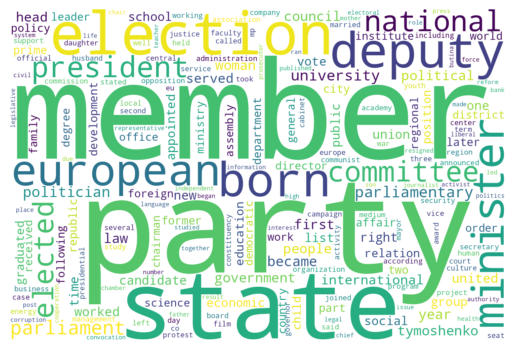

In [ ]:
# WordCloud based on all the tokens
# combine all tokens into one string
text = ""
for token_list in all_tokens:
    for token in token_list:
        text = text + " " + token

# Create and generate a word cloud image:
# https://www.datacamp.com/tutorial/wordcloud-python - parameters
wordcloud = WordCloud(background_color = "white", collocations = False,
                      width = 1500, height = 1000, stopwords = None).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bigrams

In [ ]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the articles:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])

bigram_df.head(20)

Number of unique bigrams in the articles: 105047


,bigram,count
0,"(prime, minister)",302
1,"(parliamentary, election)",293
2,"(born, politician)",281
3,"(european, parliament)",209
4,"(human, right)",163
5,"(united, state)",140
6,"(people, deputy)",139
7,"(deputy, state)",125
8,"(european, union)",124
9,"(member, parliament)",115


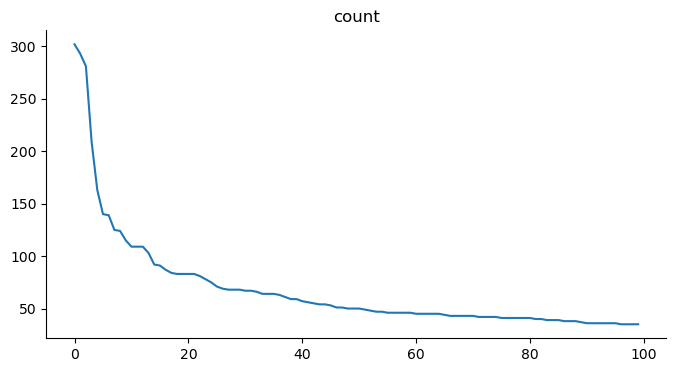

In [ ]:
# @title count
bigram_df['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Writing top 100 bigrams for all articles by frequency to a CSV file
bigram_df.to_csv('output/EE_NG_bigrams_100.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


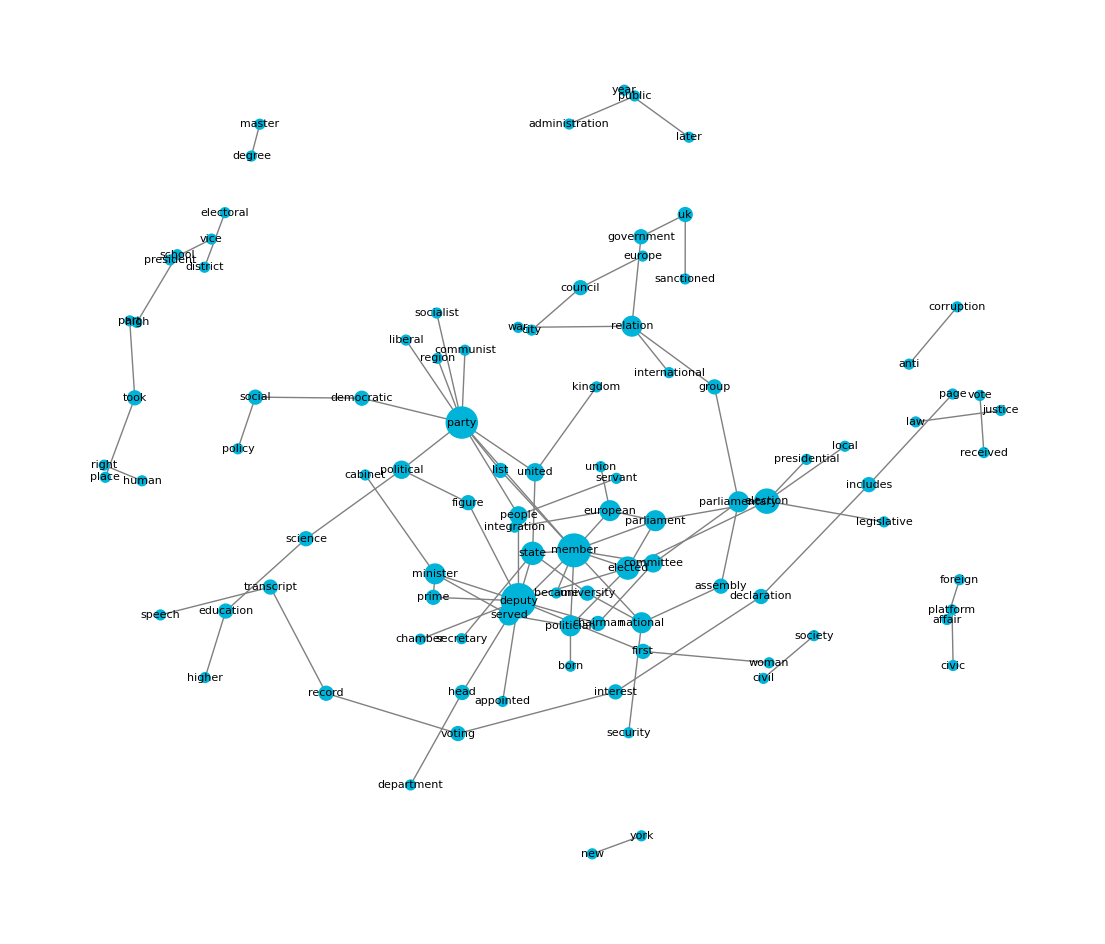

In [ ]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(14, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',
        with_labels = True,
        nodelist=d.keys(),
        node_size=[v * 50 for v in d.values()])
plt.show()

In [ ]:
# https://github.com/oliviatan29/network_analysis/tree/main
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

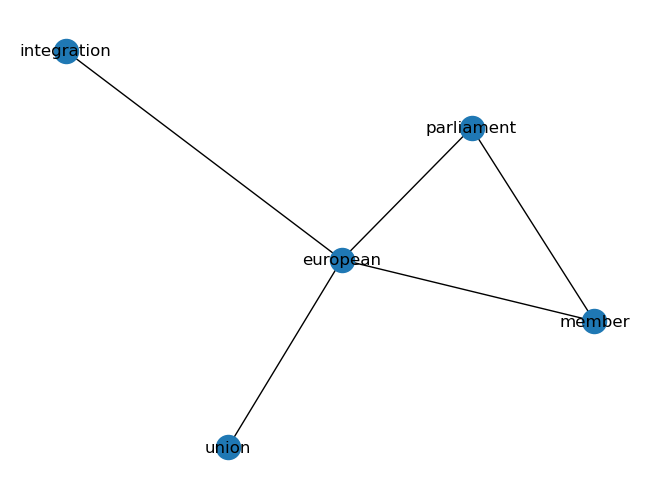

In [ ]:
# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(G, ['european'])

# Draw the subgraph to the screen
nx.draw(T_draw, with_labels=True)
plt.show()

In [ ]:
# Or as a list
list(G.adj['politician'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['born', 'member', 'served', 'elected']

## Trigrams

In [ ]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_)

print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of documents with trigrams: 339
Number of unique trigrams: 41

Top 20 trigrams by frequency

1. deputy_prime_minister - 41
2. born_politician_served - 38
3. born_politician_elected - 36
4. political_figure_deputy - 33
5. term_representing_constituency - 31
6. sanctioned_uk_government - 26
7. national_assembly_mp - 25
8. inter_parliamentary_relation - 24
9. committee_foreign_affair - 23
10. tara_national_university - 22
11. foreign_affair_minister - 21
12. servant_people_party - 20
13. candidate_presidential_election - 19
14. former_prime_minister - 19
15. right_bear_arm - 19
16. born_politician_serving - 18
17. government_relation_war - 17
18. state_sanctioned_uk - 16
19. ministry_foreign_affair - 15
20. archived_wayback_machine - 15


In [ ]:
# Writing top 20 trigrams for all articles by frequency to a CSV file
top_trigram_df = pd.DataFrame(trigram_most_freq[:20])
top_trigram_df.columns = ['trigram', 'frequency']
top_trigram_df.to_csv('output/EE_NG_trigrams_20.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

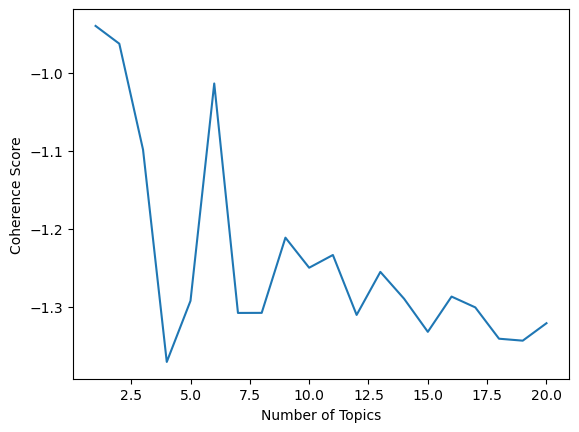

In [ ]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                             iterations = 10, num_topics = i,
                             workers = 4, passes = 10,
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

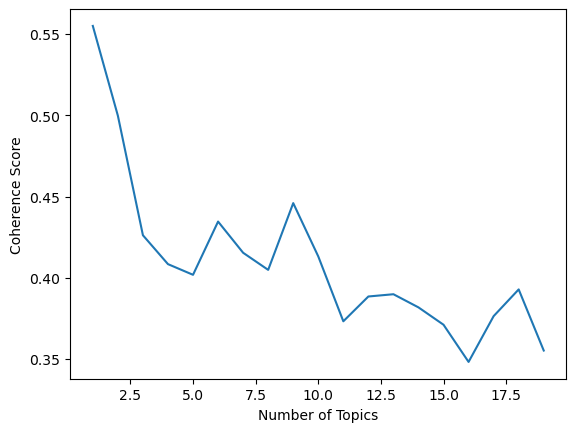

In [ ]:
# Calculating the coherence score using C_v
# also cm.get_coherence_per_topic()
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary,
                             iterations=300, num_topics=i,
                             workers = 4, passes=30, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus,
                        dictionary=dictionary,
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## LDA model

In [ ]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                         iterations = 100, num_topics = 3,
                         workers = 4, passes = 10,
                         random_state = 100)

cm_u_mass = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
u_mass_score = cm_u_mass.get_coherence()

cm_cv = CoherenceModel(model = lda_model, texts = all_tokens, corpus = corpus,
                    dictionary=dictionary,coherence='c_v')
cv_score = cm_cv.get_coherence()

print('LDA model coherence score. \nu-mass:', u_mass_score,'\n c_v:', cv_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

LDA model coherence score. 
u-mass: -1.3010304330517968 
 c_v: 0.4137209891008808

Topic: 0 
Words: 0.009*"state" + 0.008*"deputy" + 0.008*"european" + 0.008*"party" + 0.007*"parliament" + 0.006*"committee" + 0.006*"election" + 0.005*"united" + 0.005*"republic" + 0.005*"minister"

Topic: 1 
Words: 0.056*"term" + 0.050*"representing" + 0.044*"constituency" + 0.025*"senate" + 0.022*"previously" + 0.018*"died" + 0.016*"elected" + 0.013*"age" + 0.012*"served" + 0.011*"film"

Topic: 2 
Words: 0.020*"minister" + 0.017*"page" + 0.017*"voting" + 0.017*"transcript" + 0.016*"justice" + 0.016*"getting" + 0.016*"includes" + 0.016*"record" + 0.015*"declaration" + 0.014*"speech"


## LDA Visualisation

In [ ]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002470 -0.057198       1        1  79.973351
2     -0.087325  0.027368       2        1  12.519575
1      0.084855  0.029830       3        1   7.507074, topic_info=             Term       Freq      Total Category  logprob  loglift
204          term  19.000000  19.000000  Default  30.0000  30.0000
535  constituency  19.000000  19.000000  Default  29.0000  29.0000
415  representing  15.000000  15.000000  Default  28.0000  28.0000
122      minister  26.000000  26.000000  Default  27.0000  27.0000
262       elected  18.000000  18.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
72         father   0.917481   6.710669   Topic3  -5.7319   0.5995
293         local   1.104502  10.174937   Topic3  -5.5464   0.3688
202       teacher   1.078770  10.165390   Topic3  -5.5699   0.3462
242          city   1.038689  13.966359   Topic3  -5.6078  -0.0094
142    parliament   1.103683  25.883489   Topic3  -5.5471  -0.5656

[167 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
362       1  0.430820       age
362       3  0.574426       age
10        1  0.735910  assembly
10        2  0.267604  assembly
16        1  0.900680    became
...     ...       ...       ...
334       1  0.906238    worked
334       2  0.075520    worked
229       1  0.922450      year
229       2  0.070958      year
229       3  0.070958      year

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## Bigram visualisation - Node colouring by topic

In [ ]:
# Creating dataframe with node names and topics identified by LDA for colour coding nodes
# ISSUE: many words do not have topics - bigrams in dictionary?
#->> These tokens are not in the dictionary (as bigrams are build based on full token list)
nodes_df = pd.DataFrame(list(G.nodes), columns=['nodes'])

# After LDA model is built
topic_list = []
for word in nodes_df.nodes:
    try:
        t_probability = lda_model.get_term_topics(word)
        # Find for the topic with the highest probability
        if len(t_probability) > 1:
            highest_topic = ''
            highest_probability = 0
            for topic, prob in t_probability:
                if prob > highest_probability:
                    highest_topic = topic
                    highest_probability = prob
            topic_list.append(highest_topic)
        else:
            topic_list.append(t_probability[0][0])
    except (RuntimeError, TypeError, NameError, IndexError):
        topic_list.append('')
        pass
nodes_df['topic'] = topic_list
# Convert topic column to catgorical
nodes_df['topic'] = pd.Categorical(nodes_df['topic'])

nodes_df.head(10)

,nodes,topic
0,prime,2
1,minister,2
2,parliamentary,2
3,election,6
4,born,
5,politician,
6,european,0
7,parliament,0
8,human,
9,right,3


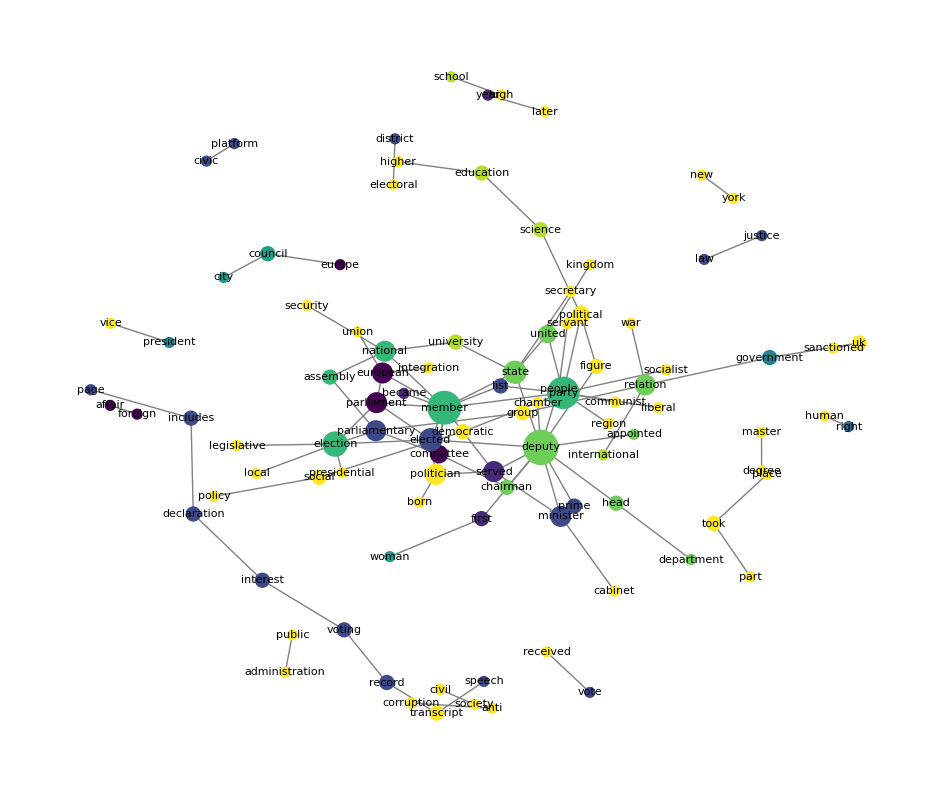

In [ ]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color = nodes_df['topic'].cat.codes,
        with_labels = True,
        nodelist=d.keys(),
        node_size=[v * 50 for v in d.values()])
plt.show()

In [ ]:
# 0 - dark purple (e.g. party)
# NA - yellow (common across all documents)

print('Number of nodes per topic:')
print(nodes_df['topic'].value_counts().sort_index())

Number of nodes per topic:
topic
0     6
1     4
2    18
3     1
4     2
5     3
6     5
7     8
8     6
     47
Name: count, dtype: int64


## Testing model

In [ ]:
# probability of a word belonging to a topic
test_words = ['european', 'woman', 'served', 'elected']
for word in test_words:
    try:
        t_probability = lda_model.get_term_topics(word)
        print('\nWord:', word, ' - belongs to:')
        for topic, prob in t_probability:
             print('Topic: {} \nProbability: {}\n'.format(topic, prob))
    except IndexError:
        pass


Word: european  - belongs to:

Word: woman  - belongs to:

Word: served  - belongs to:
Topic: 1 
Probability: 0.010360240004956722

Topic: 2 
Probability: 0.01010522898286581


Word: elected  - belongs to:
Topic: 1 
Probability: 0.014229546301066875



In [ ]:
query = 'leadership self-efficacy or LSE an individual confidence  his  her ability to carry out necessary leadership behaviors, such  delegating, making decisions, motivating others'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]
# This shows how the query relates to the topics
vec_lda

[(0, 0.8546779), (1, 0.07423394), (2, 0.071088195)]